In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd

# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [6]:
x_train_close = x_train[:,:,4] 
y_train_close = y_train[:,:,4] 
x_test_close = x_test[:,:,4] 

close_prices = np.concatenate([x_train_close, y_train_close], axis = 1) 
close_prices.shape


(7661, 1500)

In [7]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape

(7661, 1500, 10)

In [8]:
# only use close prices for this version 
OHLC = full_df[:,:,1:5] 
OHLC.shape

(7661, 1500, 4)

# Preprocess Data

In [9]:
K = 120 
N = 60 
seq_len = 1500 
features = 1
X = [] 
Y = [] 

for j in tqdm(range(close_prices.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X.append(close_prices[j, i:i+N]) 
        Y.append(close_prices[j, i+N+K]) # get close prices as target
        i += 1   
        
        
X = np.asarray(X) 
Y = np.asarray(Y)

X.shape, Y.shape


100%|██████████| 7661/7661 [00:09<00:00, 770.04it/s]


((10112520, 60), (10112520,))

In [10]:
X = X.reshape((-1,N,1)) 
X.shape 

(10112520, 60, 1)

# Define Model

In [11]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [13]:
## build model 
def build_model(): 
    time_embedding = Time2Vector(N)
    inputs = Input((N,1)) # (batch_size, timesteps, features)
    bn = BatchNormalization()(inputs) 
    x = time_embedding(bn) 
    x = Concatenate()([bn, x])  
    gru = GRU(128, return_sequences = True)(x)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = True)(gru)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = False)(gru)  
    dense = Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(gru) 
    dense = BatchNormalization()(dense) 
    outputs = Dense(1, activation = 'relu')(dense) 
    model = Model(inputs=inputs, outputs = outputs) 
    model.compile(loss='mse', optimizer = 'adam', metrics = ['mae', 'mape'])
    return model


In [14]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 1)        4           input_1[0][0]                    
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 60, 2)        240         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 3)        0           batch_normalization[0][0]        
                                                                 time2_vector[0][0]           

In [15]:
model_path = 'GRU_close_time2vec_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                    Y, 
                    batch_size = 128, ## avoid OOM 
                    epochs = 50, 
                    callbacks = [learning_rate_reduction, checkpoint, early_stopping], 
                    validation_split = 0.1)


Epoch 1/50
71104/71104 [==============================] - 1236s 17ms/step - loss: 0.0036 - mae: 0.0175 - mape: 1.7489 - val_loss: 3.0858e-04 - val_mae: 0.0098 - val_mape: 0.9786

Epoch 00001: val_loss improved from inf to 0.00031, saving model to GRU_close_time2vec_epoch_001_val_0.000.h5
Epoch 2/50
71104/71104 [==============================] - 1169s 16ms/step - loss: 2.9794e-04 - mae: 0.0114 - mape: 1.1437 - val_loss: 3.9102e-04 - val_mae: 0.0115 - val_mape: 1.1447

Epoch 00002: val_loss did not improve from 0.00031
Epoch 3/50
71104/71104 [==============================] - 1162s 16ms/step - loss: 2.9470e-04 - mae: 0.0112 - mape: 1.1225 - val_loss: 6.3138e-04 - val_mae: 0.0205 - val_mape: 2.0579

Epoch 00003: val_loss did not improve from 0.00031
Epoch 4/50
71104/71104 [==============================] - 1169s 16ms/step - loss: 2.7789e-04 - mae: 0.0108 - mape: 1.0818 - val_loss: 2.9976e-04 - val_mae: 0.0099 - val_mape: 0.9835

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



65612/71104 [==========================>...] - ETA: 1:24 - loss: 2.6479e-04 - mae: 0.0103 - mape: 1.0313

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71104/71104 [==============================] - 1154s 16ms/step - loss: 2.6529e-04 - mae: 0.0103 - mape: 1.0321 - val_loss: 2.7049e-04 - val_mae: 0.0095 - val_mape: 0.9518

Epoch 00011: val_loss improved from 0.00027 to 0.00027, saving model to GRU_close_time2vec_epoch_011_val_0.000.h5
Epoch 12/50
71104/71104 [==============================] - 1162s 16ms/step - loss: 2.5912e-04 - mae: 0.0102 - mape: 1.0197 - val_loss: 2.6849e-04 - val_mae: 0.0095 - val_mape: 0.9524

Epoch 00012: val_loss improved from 0.00027 to 0.00027, saving model to GRU_close_time2vec_epoch_012_val_0.000.h5
Epoch 13/50
71104/71104 [==============================] - 1155s 16ms/step - loss: 2.5534e-04 - mae: 0.0101 - mape: 1.0150 - val_loss: 2.6652e-04 - val_mae: 0.0095 - val_mape: 0.9528

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00013: val_loss improved from 0.00027 to 0.00027, saving model to GRU_close_time2vec_epoch_013_val_0.000.h5
Epoch 14/50
71104/71104 [=============

KeyboardInterrupt: 

# Make Prediction

In [17]:
best_model1 = load_model('GRU_close_time2vec_epoch_012_val_0.000.h5', custom_objects = {'Time2Vector':Time2Vector}) 
best_model1.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 1)        4           input_1[0][0]                    
__________________________________________________________________________________________________
time2_vector_1 (Time2Vector)    (None, 60, 2)        240         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 3)        0           batch_normalization[0][0]        
                                                                 time2_vector_1[0][0]         

In [19]:
best_model2 = load_model('GRU_close_time2vec_epoch_013_val_0.000.h5', custom_objects={'Time2Vector':Time2Vector})
best_model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 1)        4           input_1[0][0]                    
__________________________________________________________________________________________________
time2_vector_3 (Time2Vector)    (None, 60, 2)        240         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 3)        0           batch_normalization[0][0]        
                                                                 time2_vector_3[0][0]         

In [32]:
## We need to preprocess inputs for prediction 
X_test = [] 
for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-N-K-120, seq_len-N-K):
        X_test.append(x_test_close[j, i:i+N])  

X_test = np.asarray(X_test).reshape((-1,N,1))


100%|██████████| 535/535 [00:00<00:00, 16578.52it/s]


In [33]:
pred1 = best_model1.predict(X_test) 
pred1 = pred1.reshape((-1,120))

In [34]:
pred2 = best_model2.predict(X_test) 
pred2 = pred2.reshape((-1,120)) 

In [35]:
pred1.shape, pred2.shape

((535, 120), (535, 120))

In [36]:
pred_avg = (pred1 + pred2) / 2.0 
pred_avg.shape

(535, 120)

In [42]:
## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(pred_avg.shape[0]), position = 0, leave = True):
    buy_price = x_test_close[i,-1] 
    if pred_avg[i,0] > buy_price:
        diff = pred_avg[i,0] - buy_price 
        pred_avg[i,:] -= diff 
    elif pred_avg[i,0] < buy_price:  
        diff = buy_price - pred_avg[i,0] 
        pred_avg[i,:] += diff 
        

100%|██████████| 535/535 [00:00<00:00, 126827.14it/s]


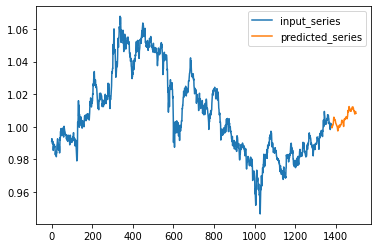

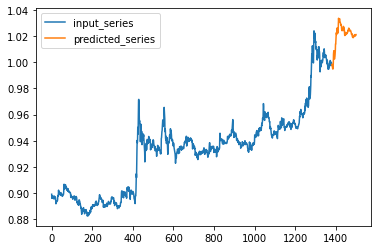

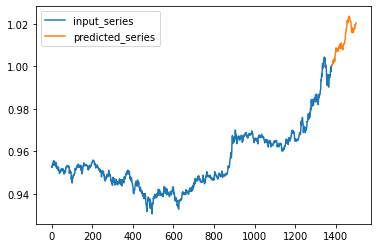

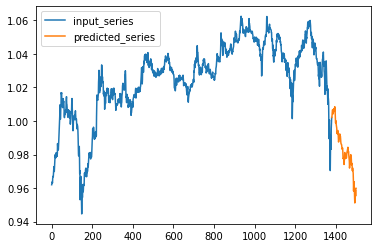

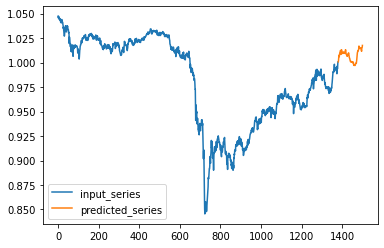

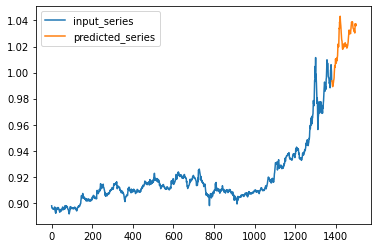

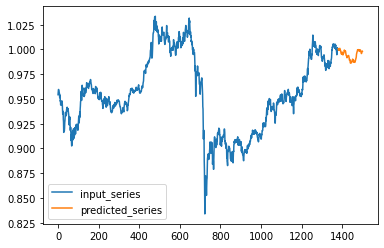

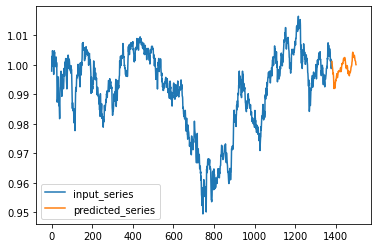

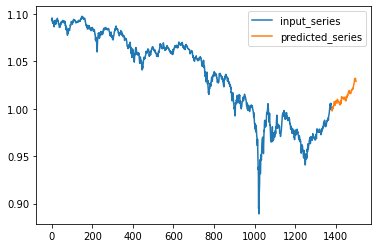

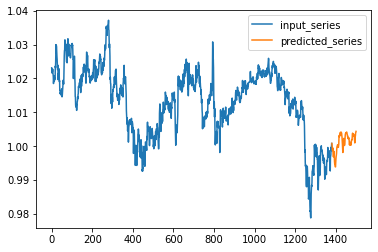

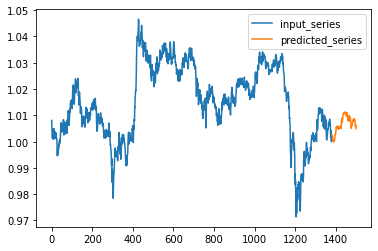

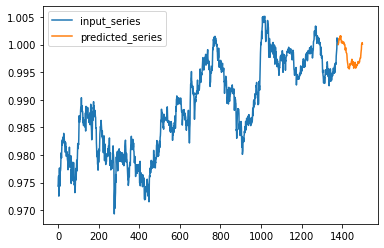

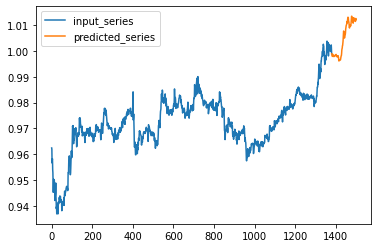

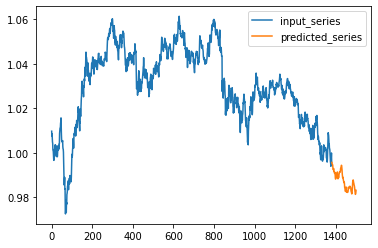

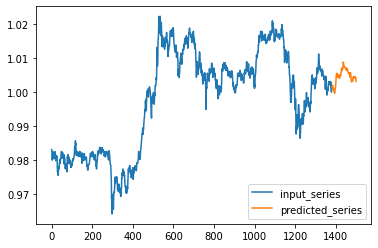

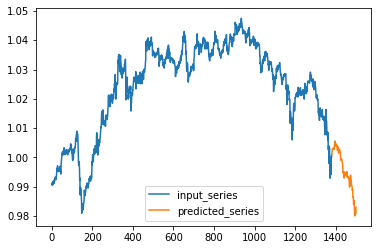

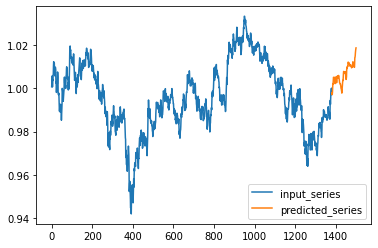

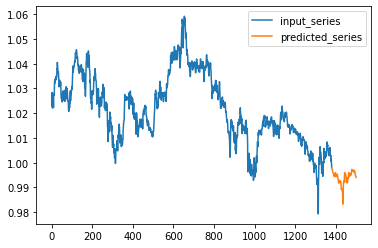

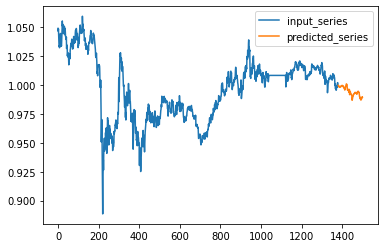

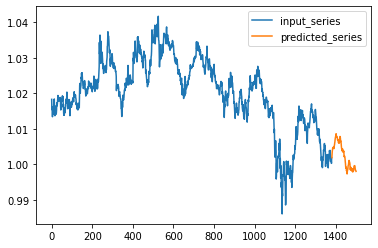

In [43]:
for i in range(20): 
    plt.plot() 
    plot_predicted_series(x_test_close[i,:], pred_avg[i,:])
    plt.show()


In [44]:
## create submission dataframe 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(pred_avg.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(pred_avg[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(120): 
        if pred_avg[i,j] >= buy_price:  
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)


100%|██████████| 535/535 [00:00<00:00, 3935.16it/s]


In [45]:
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times 

submission

,sample_id,buy_quantity,sell_time
0,7661,0.891667,85
1,7662,0.950000,33
2,7663,0.991667,84
3,7664,0.150000,14
4,7665,0.808333,119
...,...,...,...
530,8191,0.091667,9
531,8192,0.116667,77
532,8193,0.908333,73
533,8194,0.033333,1


In [46]:
submission.to_csv("GRU_Time2Vec_normalized_predictions.csv",index=False) 

# Visualize Plots

In [47]:
pred_train1 = best_model1.predict(X[:2400,])
pred_train2 = best_model2.predict(X[:2400,])

pred_avg_train = (pred_train1 + pred_train2) / 2.0 

pred_avg_train = pred_avg_train.reshape((-1,120))
pred_avg_train.shape

(20, 120)

In [48]:
for i in tqdm(range(pred_avg_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_close[i,-1] 
    if pred_avg_train[i,0] > buy_price:
        diff = pred_avg_train[i,0] - buy_price 
        pred_avg_train[i,:] -= diff 
    elif pred_avg_train[i,0] < buy_price:  
        diff = buy_price - pred_avg_train[i,0] 
        pred_avg_train[i,:] += diff 

100%|██████████| 20/20 [00:00<00:00, 56036.13it/s]


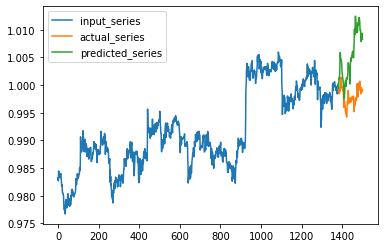

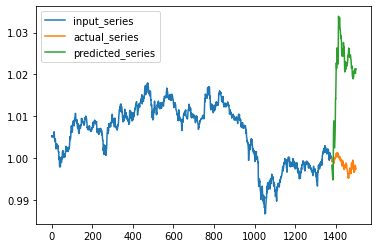

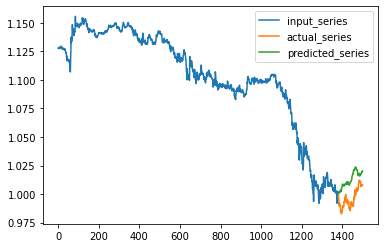

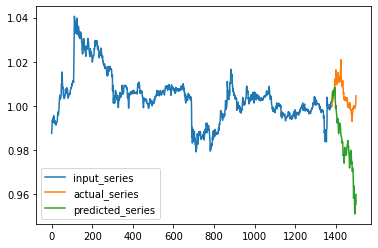

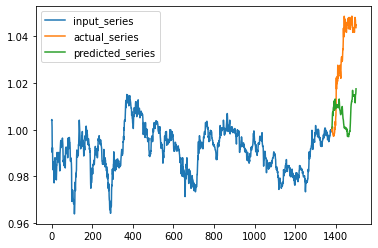

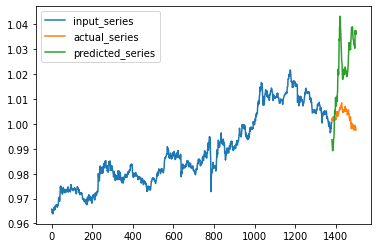

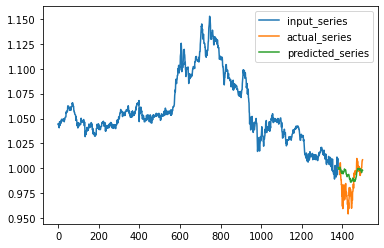

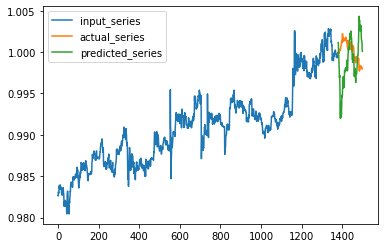

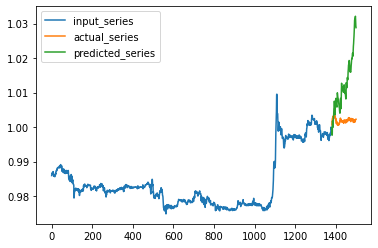

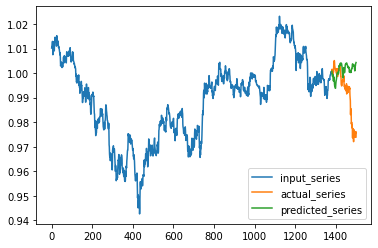

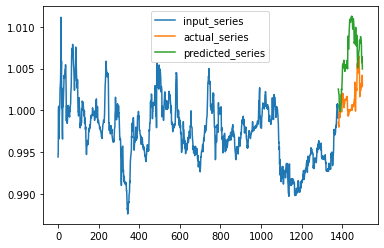

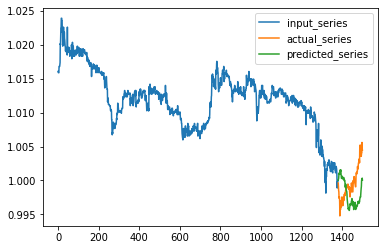

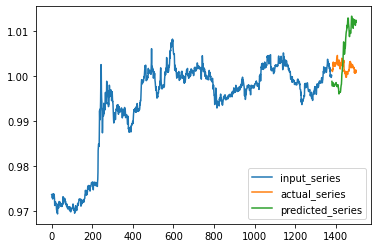

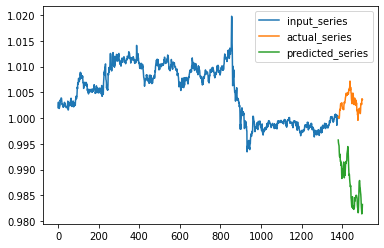

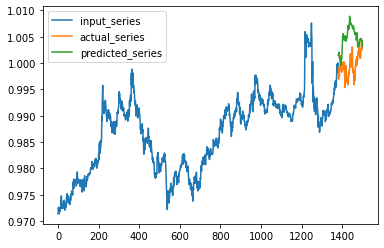

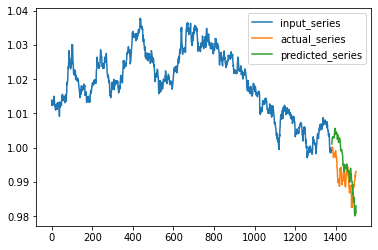

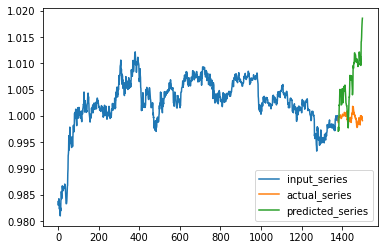

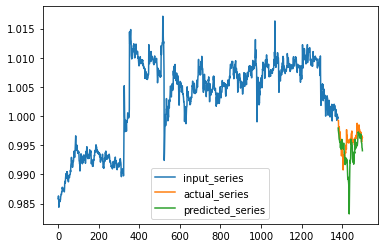

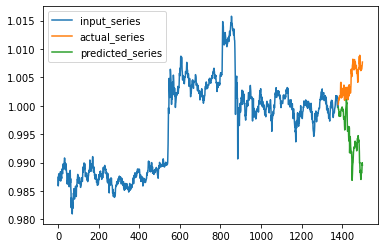

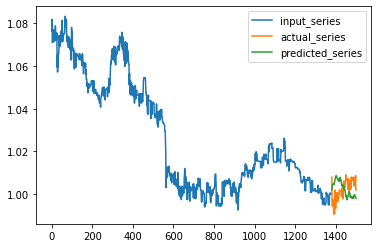

In [49]:
for i in range(20): 
    plt.plot() 
    plot_series(x_train_close[i,:], y_train_close[i,:], pred_avg[i,:])
    plt.show()
